In [1]:
import numpy as np 
import pandas as pd 

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# For data preprocessing
# !pip install geopy
import time
import geopy
from geopy.geocoders import Nominatim
from time import sleep
from random import randint

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# Data Pre-processing Stage-1: **Importing and Cleaning data**

In [2]:
# Reading the files
df_banglore = pd.read_csv('Bangalore.csv')
df_chennai  = pd.read_csv('Chennai.csv')
df_delhi    = pd.read_csv('Delhi.csv')
df_hyderabad= pd.read_csv('Hyderabad.csv')
df_kolkata  = pd.read_csv('Kolkata.csv')
df_mumbai   = pd.read_csv('Mumbai.csv')

##### Combining the files into one #####
df_banglore['City']='Banglore'
df_chennai['City']='Chennai'
df_delhi['City']='Delhi'
df_hyderabad['City']='Hyderabad'
df_kolkata['City']='Kolkata'
df_mumbai['City']='Mumbai'

df=pd.concat([df_banglore, df_chennai, df_delhi, df_hyderabad, df_kolkata, df_mumbai]).reset_index(drop=True)

In [3]:
# The digit '9' seems to be used to indicate the absence of information about certain predictor variables. 
# We'll clean the dataframe by dropping these values.
df.replace(9, np.nan, inplace=True)
df.dropna(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10093 entries, 0 to 26641
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                10093 non-null  int64  
 1   Area                 10093 non-null  int64  
 2   Location             10093 non-null  object 
 3   No. of Bedrooms      10093 non-null  float64
 4   Resale               10093 non-null  int64  
 5   MaintenanceStaff     10093 non-null  float64
 6   Gymnasium            10093 non-null  float64
 7   SwimmingPool         10093 non-null  float64
 8   LandscapedGardens    10093 non-null  float64
 9   JoggingTrack         10093 non-null  float64
 10  RainWaterHarvesting  10093 non-null  float64
 11  IndoorGames          10093 non-null  float64
 12  ShoppingMall         10093 non-null  float64
 13  Intercom             10093 non-null  float64
 14  SportsFacility       10093 non-null  float64
 15  ATM                  10093 non-null 

In [5]:
# When no. of training samples corresponding to a particular location are very less, 
# then it is hard to predict price accurately for test data in that specific location. 
# Hence, to improve accuracy, we are removing data points whole location appears very rare in the dataset (<=10). 
loc_stats=df.groupby('Location')['Location'].agg('count').sort_values(ascending=False)
loc_stats_less_than_10=loc_stats[loc_stats<=10]
df.Location=df.Location.apply(lambda x: 'other' if x in loc_stats_less_than_10 else x)
df.replace('other', np.nan, inplace=True)
df.dropna(inplace=True)

# Converting rupees to lakhs
# RUN THIS ONLY ONCE OTHERWISE PRICE WILL BE REDUCED BY A FACTOR OF 10^5 MULTIPLE TIMES!
df['Price']= df['Price']/10**5

In [6]:
# Adding the latitute and longitute for the places
location=Nominatim(user_agent='user_me_{}'.format(randint(10000,99999))) 
def get_location_code(x):
    try:                                                           ## Error handling using try and catch block!
        cordinates=location.geocode(x, country_codes='in')
        return cordinates.latitude, cordinates.longitude  
    except:
        time.sleep(0.030)
        return "Not found"

# Finding lat/long for unique loactions only for speeding up execution
unique_location=df['Location'].unique()
location_to_code={}
for place in unique_location:
    location_to_code[place]=get_location_code(place) # This took 6 mins for me! Save this cleaned csv!

print(location_to_code)
# Creating two new columns having latitude and longitude
df['Latitude'],df['Longitude']=zip(*df['Location'].map(location_to_code))

# Removing the 'Not found' records
df=df[df['Latitude']!='Not found'].reset_index(drop=True)
df=df[df['Latitude']!='N'].reset_index(drop=True)

{'Kannur on Thanisandra Main Road': 'Not found', 'Doddanekundi': (12.9713194, 77.6964768), 'Horamavu': (13.0273312, 77.6601508), 'Thanisandra': (13.054713, 77.6339258), 'Ramamurthy Nagar': (13.0120218, 77.6777817), 'Whitefield Hope Farm Junction': (12.9828923, 77.75331443178575), 'Electronic City Phase 1': (12.8496783, 77.6649749), 'Yelahanka': (13.1006982, 77.5963454), 'Anjanapura': (12.6847039, 77.2711718), 'Jalahalli': (13.6510577, 77.4305219), 'Kasavanahalli': (14.2042644, 76.5173044), 'Bommasandra': (12.8162443, 77.6916113), 'Bellandur': (12.93577245, 77.66676103753434), 'RR Nagar': (9.46693815, 77.93356445178478), 'Begur': (12.8633887, 77.61301120503904), 'Hosa Road': (12.8705404, 77.6540853), 'Sahakar Nagar': (18.4900796, 73.8475301), 'Kadugodi': (12.9985767, 77.7609716), 'Jakkur': (13.0784743, 77.6068938), 'Jigani': (12.7852528, 77.6380931), 'Krishnarajapura': (12.0325216, 76.8056333), 'Banashankari': (15.8876779, 75.7046777), 'Nelamangala': (13.0953024, 77.3963586), 'Attibele'

In [7]:
# Saving the cleaned data file as it takes plenty of time build.
df.to_csv('HM-All_Cities_Cleaned_1.csv', index=False)

file_path='HM-All_Cities_Cleaned_1.csv'
df=pd.read_csv(file_path, index_col=False)

# Data Pre-processing Stage-2: **Feature Selection** 

Using a lot of predictors (~40 here!) often leads to model inefficiency and inaccuracy. We'll only select those few features that are highly relevant for our prediction of housing price. Moreover, if two separate feature haves high correlation, it implies both have an almost linear relationship with each other. Thus, we can drop one of them!

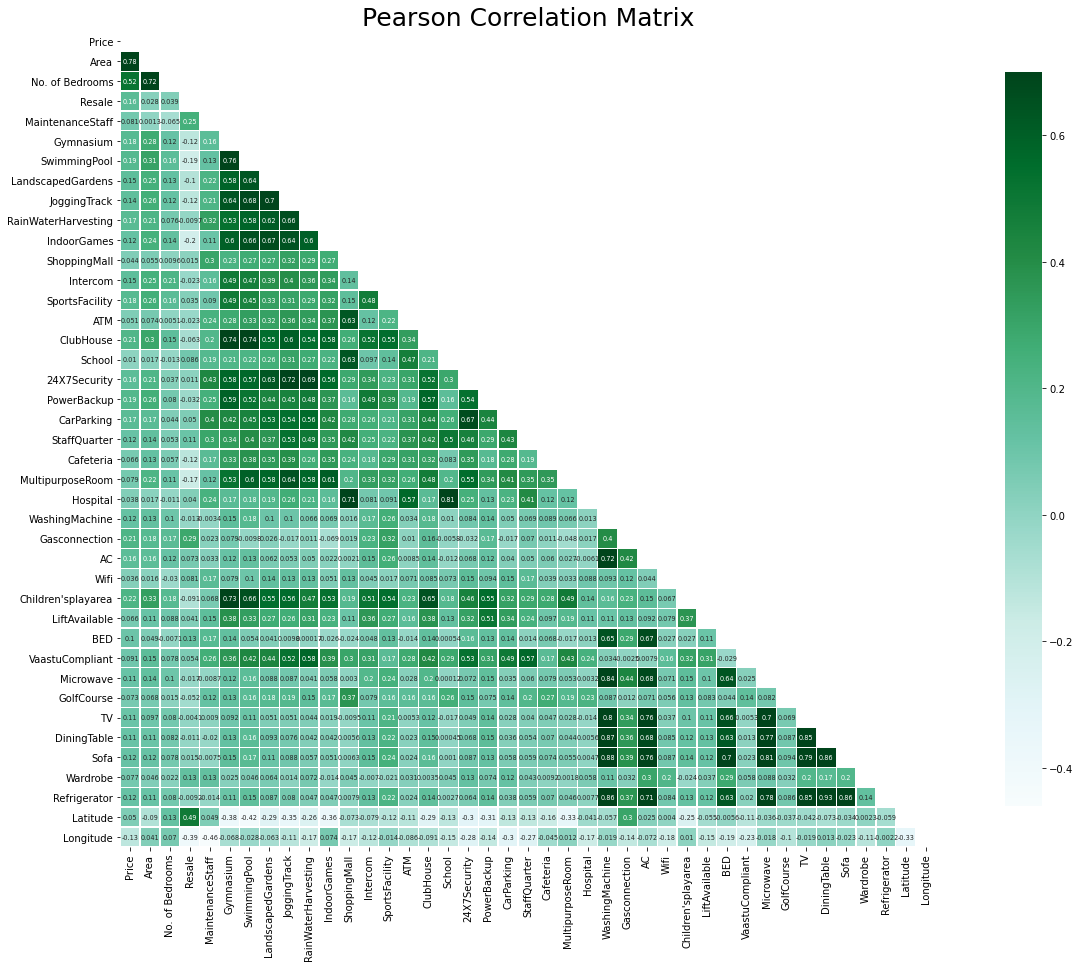

In [8]:
# Correlation between predictor variables and output variable

features1 = df.columns.values

mask = np.zeros_like(df[features1].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(25, 15))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features1].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":6.5},mask=mask,cbar_kws={"shrink": .9});

**Statistical way of selecting features:**

We'll drop all features having correlation with Price < 0.15 and we'll drop one feature amongst two if their correlation > 0.7. Hence, we selected the following features - **Location, Area, Number of bedrooms, Swimming Pool, Power backup, GasConnection, AC, Children's Play Area**

**Intuitively selecting the features:**

Keeping the correlations between predictor and output variables in mind, we removed some features and included only those that seem important from a buyer/seller's point of view. Thre feature set we decided here is - **'Area','Location','City','No. of Bedrooms','Gymnasium','CarParking','Hospital'**

**FINAL FEATURE SET:**

We ran our model on the whole feature set, and the above two feature sets and recorded the accuracies. We got the highest accuracy for the feature set - [ 'Area' , 'Location' , 'City' , 'No. of Bedrooms' , 'Gymnasium' , 'CarParking' , 'Hospital' ]. The other feature sets did not give high accuracy even though the correlation values were high was due to the presence of outliers. 

In [9]:
# df_1 = df[['Price','Area','Location','City','No. of Bedrooms','SwimmingPool','PowerBackup','Gasconnection','AC',"Children'splayarea"]]
# df_1 = df.copy()
df_1 = df[['Price','Area','Location','City','No. of Bedrooms','Gymnasium','CarParking','Hospital','Latitude','Longitude']]

# Data Pre-processing Stage-3: **Exploratory Data Analysis**

We'll perform some inital data plotting to visualise any potential outliers and possible patterns

**VARIATION OF HOUSE PRICES:**

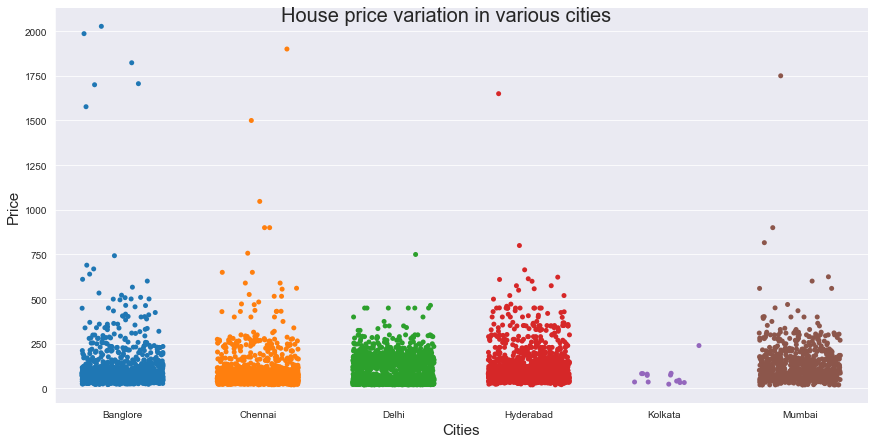

In [10]:
def plot_city_variation(col_name, title, df):
    sns.set_style("darkgrid") # Background grid style
    ax=sns.catplot(x='City', y=col_name, data=df, jitter=0.3, height=6, aspect=2)

    # For aesthetic purpose
    ax.fig.suptitle(title, fontsize=20);
    ax.set_xlabels('Cities',fontsize=15);
    ax.set_ylabels(col_name,fontsize=15);

plot_city_variation('Price', 'House price variation in various cities',df_1)

Some houses in Mumbai seem to have prices greater than INR 35 crore! We'll remove these **luxurious outlier points (> INR 1 crore)** before training our models.

**OUTLIER REMOVAL:**


1.   We'll first create a temporary column of per square feet rate in our dataframe and drop any unrealistic values that are beyond μ-3σ



In [11]:
df1 = df_1.copy()
df1['price_per_sqft'] = df1['Price']*100000/df1['Area']
df1.price_per_sqft.describe()

count     7677.000000
mean      6768.579139
std       3669.013659
min       2000.000000
25%       4571.428571
50%       5620.915033
75%       7826.086957
max      91960.063058
Name: price_per_sqft, dtype: float64

In [12]:
def Remove_PPS_Outliers(df):
    df_out=pd.DataFrame()
    for key,subdf in df.groupby('Location'):
        m=np.mean(subdf.price_per_sqft)
        st=np.std(subdf.price_per_sqft)
        reduced_df=subdf[(subdf.price_per_sqft>(m-3*st))&(subdf.price_per_sqft<=(m+3*st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

df2=Remove_PPS_Outliers(df1)
df2 = df2[(df2.Price<=(1000.0))] # Prices less than 1 crore are considered.  
# plot_city_variation('Price', 'House price variation in various cities',df2)

**Note:** About 374 data points (4 %) got dropped due to removing over luxurious or unnaturally low price per sqft houses!

In [13]:
# drop the price_per_sqft column that was created temporarily
df3 = df2.drop(['price_per_sqft'],axis='columns')

# When no. of training samples corresponding to a particular location are very less, 
# then it is hard to predict price accurately for test data in that specific location. 
# Hence, to improve accuracy, we are removing data points whole location appears very rare in the dataset (<=10). 
loc_stats=df3.groupby('Location')['Location'].agg('count').sort_values(ascending=False)
loc_stats_less_than_10=loc_stats[loc_stats<=10]
df3.Location=df3.Location.apply(lambda x: 'other' if x in loc_stats_less_than_10 else x)
df3.replace('other', np.nan, inplace=True)
df3.dropna(inplace=True)


df3=df3[~(df3.Area/df3['No. of Bedrooms']<300)]
df3=df3[~(df3.Area/df3['No. of Bedrooms']>900)]

Since **'Location'** is a categorical variable, we'll have to convert all location values as a binary 0/1 feature before using regression or classification models

In [14]:
df4 = df3.copy()
dummies = pd.get_dummies(df4.Location)

df5 = pd.concat([df4,dummies],axis='columns')
df6=df5.drop('Location',axis='columns')
df6.to_csv('HM-All_Cities_Cleaned_Final.csv', index=False)

df7 = df6.drop('City',axis='columns')
df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6927 entries, 0 to 7603
Columns: 214 entries, Price to tambaram west
dtypes: float64(7), int64(1), uint8(206)
memory usage: 1.8 MB


We're now in principle ready for using ANY Machine Learning model on our **dataframe df7**! -> by selecting appropriate features

**'Price'** is our response with all other columns being the predictors

# **Regression Models**

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [16]:
# We'll fill this evaluation df with results/scores dumped by different models and compare them at the end!
evaluation = pd.DataFrame({'Model Name': [],
                           'Details':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'R-squared (training)':[],
                           'Adjusted R-squared (training)':[],
                           'R-squared (test)':[],
                           'Adjusted R-squared (test)':[],
                           '5-Fold Cross Validation':[]})

def adjustedR2(r2,n,k):        ## n=num of observations and k=num of parameters
    return r2-(k-1)/(n-k)*(1-r2)

# Train and test data
train_data,test_data = train_test_split(df7,train_size = 0.8,random_state=10)

**SIMPLE LINEAR REGRESSION** - The predictor variable is 'Area'

In [17]:
lr = linear_model.LinearRegression()
X_train = np.array(train_data['Area'], dtype=pd.Series).reshape(-1,1)
y_train = np.array(train_data['Price'], dtype=pd.Series)
lr.fit(X_train,y_train)

X_test = np.array(test_data['Area'], dtype=pd.Series).reshape(-1,1)
y_test = np.array(test_data['Price'], dtype=pd.Series)

pred = lr.predict(X_test)
rmse_lr = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtr_lr = float(format(lr.score(X_train, y_train),'.3f'))
rte_lr = float(format(lr.score(X_test, y_test),'.3f'))
cv = float(format(cross_val_score(lr,df[['Area']],df['Price'],cv=5).mean(),'.3f'))

print ("Average Price for Test Data using Area as the only predictor : {:.3f}".format(y_test.mean()))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficient: {}'.format(lr.coef_))

r = evaluation.shape[0]
evaluation.loc[r] = ['Simple Linear Regression','-',rmse_lr,rtr_lr,'-',rte_lr,'-',cv]
evaluation

Average Price for Test Data using Area as the only predictor : 93.703
Intercept: -33.75627587824658
Coefficient: [0.09435739]


,Model Name,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple Linear Regression,-,47.907,0.555,-,0.549,-,0.576


**MULTIPLE LINEAR REGRESSION WITH SELECTED FEATURES:**

In [18]:
features = df7.columns
features = features.drop('Price')
features = features.drop('Latitude')
features = features.drop('Longitude')

train_data_2,test_data_2 = train_test_split(df7,train_size = 0.8,random_state=10)

complex_model_1 = linear_model.LinearRegression()
complex_model_1.fit(train_data_2[features],train_data_2['Price'])

#print('Intercept: {}'.format(complex_model_1.intercept_))
#print('Coefficients: {}'.format(complex_model_1.coef_))

pred = complex_model_1.predict(test_data_2[features])
rmse_cm = float(format(np.sqrt(metrics.mean_squared_error(test_data_2['Price'],pred)),'.3f'))
rtr_cm = float(format(complex_model_1.score(train_data_2[features],train_data_2['Price']),'.3f'))
artr_cm = float(format(adjustedR2(complex_model_1.score(train_data_2[features],train_data_2['Price']),train_data_2.shape[0],len(features)),'.3f'))
rte_cm = float(format(complex_model_1.score(test_data_2[features],test_data_2['Price']),'.3f'))
arte_cm = float(format(adjustedR2(complex_model_1.score(test_data_2[features],test_data['Price']),test_data_2.shape[0],len(features)),'.3f'))
cv = float(format(cross_val_score(complex_model_1,df7[features],df7['Price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Multiple Regression','-',rmse_cm,rtr_cm,artr_cm,rte_cm,arte_cm,cv]
evaluation
# evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model Name,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple Linear Regression,-,47.907,0.555,-,0.549,-,5.760000e-01
1,Multiple Regression,-,23.139,0.890,0.885,0.895,0.876,-9.436590e+15


**RIDGE REGRESSION** with hyperparameter **alpha = { 1 , 100 , 1000 }**

In [19]:
complex_model_R = linear_model.Ridge(alpha=1)
complex_model_R.fit(train_data_2[features],train_data_2['Price'])

pred1 = complex_model_R.predict(test_data_2[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data_2['Price'],pred1)),'.3f'))
rtrcm1 = float(format(complex_model_R.score(train_data_2[features],train_data_2['Price']),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_R.score(train_data_2[features],train_data_2['Price']),train_data_2.shape[0],len(features)),'.3f'))
rtecm1 = float(format(complex_model_R.score(test_data_2[features],test_data_2['Price']),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_R.score(test_data_2[features],test_data_2['Price']),test_data_2.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(complex_model_R,df7[features],df7['Price'],cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=100)
complex_model_R.fit(train_data_2[features],train_data_2['Price'])

pred2 = complex_model_R.predict(test_data_2[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_2['Price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_R.score(train_data_2[features],train_data_2['Price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_R.score(train_data_2[features],train_data_2['Price']),train_data_2.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_R.score(test_data_2[features],test_data_2['Price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_R.score(test_data_2[features],test_data_2['Price']),test_data_2.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_R,df7[features],df7['Price'],cv=5).mean(),'.3f'))

complex_model_R = linear_model.Ridge(alpha=1000)
complex_model_R.fit(train_data_2[features],train_data_2['Price'])

pred3 = complex_model_R.predict(test_data_2[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data_2['Price'],pred3)),'.3f'))
rtrcm3 = float(format(complex_model_R.score(train_data_2[features],train_data_2['Price']),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_R.score(train_data_2[features],train_data_2['Price']),train_data_2.shape[0],len(features)),'.3f'))
rtecm3 = float(format(complex_model_R.score(test_data_2[features],test_data_2['Price']),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_R.score(test_data_2[features],test_data_2['Price']),test_data_2.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(complex_model_R,df7[features],df7['Price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Ridge Regression','alpha=1',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Ridge Regression','alpha=100',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Ridge Regression','alpha=1000',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation
# evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model Name,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple Linear Regression,-,47.907,0.555,-,0.549,-,5.760000e-01
1,Multiple Regression,-,23.139,0.890,0.885,0.895,0.876,-9.436590e+15
2,Ridge Regression,alpha=1,23.489,0.888,0.884,0.891,0.872,5.180000e-01
3,Ridge Regression,alpha=100,41.156,0.678,0.665,0.667,0.607,5.290000e-01
4,Ridge Regression,alpha=1000,46.528,0.581,0.565,0.574,0.498,5.280000e-01


**LASSO REGRESSION** with hyperparameter **alpha = { 1 , 100 , 1000 }**

In [20]:
complex_model_L = linear_model.Lasso(alpha=1)
complex_model_L.fit(train_data_2[features],train_data_2['Price'])

pred1 = complex_model_L.predict(test_data_2[features])
rmsecm1 = float(format(np.sqrt(metrics.mean_squared_error(test_data_2['Price'],pred1)),'.3f'))
rtrcm1 = float(format(complex_model_L.score(train_data_2[features],train_data_2['Price']),'.3f'))
artrcm1 = float(format(adjustedR2(complex_model_L.score(train_data_2[features],train_data_2['Price']),train_data_2.shape[0],len(features)),'.3f'))
rtecm1 = float(format(complex_model_L.score(test_data_2[features],test_data_2['Price']),'.3f'))
artecm1 = float(format(adjustedR2(complex_model_L.score(test_data_2[features],test_data_2['Price']),test_data_2.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(complex_model_L,df7[features],df7['Price'],cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=100)
complex_model_L.fit(train_data_2[features],train_data_2['Price'])

pred2 = complex_model_L.predict(test_data_2[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_2['Price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_L.score(train_data_2[features],train_data_2['Price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_L.score(train_data_2[features],train_data_2['Price']),train_data_2.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_L.score(test_data_2[features],test_data_2['Price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_L.score(test_data_2[features],test_data_2['Price']),test_data_2.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_L,df7[features],df7['Price'],cv=5).mean(),'.3f'))

complex_model_L = linear_model.Lasso(alpha=1000)
complex_model_L.fit(train_data_2[features],train_data_2['Price'])

pred3 = complex_model_L.predict(test_data_2[features])
rmsecm3 = float(format(np.sqrt(metrics.mean_squared_error(test_data_2['Price'],pred3)),'.3f'))
rtrcm3 = float(format(complex_model_L.score(train_data_2[features],train_data_2['Price']),'.3f'))
artrcm3 = float(format(adjustedR2(complex_model_L.score(train_data_2[features],train_data_2['Price']),train_data_2.shape[0],len(features)),'.3f'))
rtecm3 = float(format(complex_model_L.score(test_data_2[features],test_data_2['Price']),'.3f'))
artecm3 = float(format(adjustedR2(complex_model_L.score(test_data_2[features],test_data_2['Price']),test_data_2.shape[0],len(features)),'.3f'))
cv3 = float(format(cross_val_score(complex_model_L,df7[features],df7['Price'],cv=5).mean(),'.3f'))

r = evaluation.shape[0]
evaluation.loc[r] = ['Lasso Regression','alpha=1',rmsecm1,rtrcm1,artrcm1,rtecm1,artecm1,cv1]
evaluation.loc[r+1] = ['Lasso Regression','alpha=100',rmsecm2,rtrcm2,artrcm2,rtecm2,artecm2,cv2]
evaluation.loc[r+2] = ['Lasso Regression','alpha=1000',rmsecm3,rtrcm3,artrcm3,rtecm3,artecm3,cv3]
evaluation
# evaluation.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model Name,Details,Root Mean Squared Error (RMSE),R-squared (training),Adjusted R-squared (training),R-squared (test),Adjusted R-squared (test),5-Fold Cross Validation
0,Simple Linear Regression,-,47.907,0.555,-,0.549,-,5.760000e-01
1,Multiple Regression,-,23.139,0.890,0.885,0.895,0.876,-9.436590e+15
2,Ridge Regression,alpha=1,23.489,0.888,0.884,0.891,0.872,5.180000e-01
3,Ridge Regression,alpha=100,41.156,0.678,0.665,0.667,0.607,5.290000e-01
4,Ridge Regression,alpha=1000,46.528,0.581,0.565,0.574,0.498,5.280000e-01
5,Lasso Regression,alpha=1,47.444,0.566,0.549,0.557,0.478,5.230000e-01
6,Lasso Regression,alpha=100,47.911,0.555,0.538,0.549,0.468,5.240000e-01
7,Lasso Regression,alpha=1000,47.979,0.555,0.537,0.547,0.466,5.240000e-01


**POLYNOMIAL REGRESSION** with selected features

In [21]:
evaluation_poly = pd.DataFrame({'Model': [],
                                'Details':[],
                                'Root Mean Squared Error (RMSE)':[],
                                'R-squared (training)':[],
                                'Adjusted R-squared (training)':[],
                                'R-squared (test)':[],
                                'Adjusted R-squared (test)':[],
                                '5-Fold Cross Validation':[]})

#features = ['Area', 'No. of Bedrooms', 'Latitude', 'Longitude']
features = ['Area', 'No. of Bedrooms', 'Gymnasium', 'CarParking', 'Hospital']
#features = ['Area']
# features = ['Area','No. of Bedrooms','SwimmingPool','PowerBackup','Gasconnection','AC',"Children'splayarea"]




train_data,test_data = train_test_split(df7,train_size = 0.8,random_state=5)


polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df7[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['Price'])

pred1 = poly.predict(X_testpoly)
rmsepoly1 = float(format(np.sqrt(metrics.mean_squared_error(test_data['Price'],pred1)),'.3f'))
rtrpoly1 = float(format(poly.score(X_trainpoly,train_data['Price']),'.3f'))
rtepoly1 = float(format(poly.score(X_testpoly,test_data['Price']),'.3f'))
cv1 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df7['Price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=3)
X_allpoly = polyfeat.fit_transform(df7[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.LinearRegression().fit(X_trainpoly, train_data['Price'])

pred2 = poly.predict(X_testpoly)
rmsepoly2 = float(format(np.sqrt(metrics.mean_squared_error(test_data['Price'],pred2)),'.3f'))
rtrpoly2 = float(format(poly.score(X_trainpoly,train_data['Price']),'.3f'))
rtepoly2 = float(format(poly.score(X_testpoly,test_data['Price']),'.3f'))
cv2 = float(format(cross_val_score(linear_model.LinearRegression(),X_allpoly,df7['Price'],cv=5).mean(),'.3f'))

###############################################################################################################################
polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df7[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.Ridge(alpha=50000, tol=0.001).fit(X_trainpoly, train_data['Price'])

pred7 = poly.predict(X_testpoly)
rmsepoly7 = float(format(np.sqrt(metrics.mean_squared_error(test_data['Price'],pred7)),'.3f'))
rtrpoly7 = float(format(poly.score(X_trainpoly,train_data['Price']),'.3f'))
rtepoly7 = float(format(poly.score(X_testpoly,test_data['Price']),'.3f'))
cv7 = float(format(cross_val_score(linear_model.Ridge(alpha=50000, tol=0.001),X_allpoly,df7['Price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=2)
X_allpoly = polyfeat.fit_transform(df7[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.Lasso(alpha=1, tol=0.001).fit(X_trainpoly, train_data['Price'])

pred8 = poly.predict(X_testpoly)
rmsepoly8 = float(format(np.sqrt(metrics.mean_squared_error(test_data['Price'],pred8)),'.3f'))
rtrpoly8 = float(format(poly.score(X_trainpoly,train_data['Price']),'.3f'))
rtepoly8 = float(format(poly.score(X_testpoly,test_data['Price']),'.3f'))
cv8 = float(format(cross_val_score(linear_model.Lasso(alpha=1, tol=0.001),X_allpoly,df7['Price'],cv=5).mean(),'.3f'))

polyfeat = PolynomialFeatures(degree=3)
X_allpoly = polyfeat.fit_transform(df7[features])
X_trainpoly = polyfeat.fit_transform(train_data[features])
X_testpoly = polyfeat.fit_transform(test_data[features])
poly = linear_model.Lasso(alpha=50000, tol=0.001).fit(X_trainpoly, train_data['Price'])

pred9 = poly.predict(X_testpoly)
rmsepoly9 = float(format(np.sqrt(metrics.mean_squared_error(test_data['Price'],pred9)),'.3f'))
rtrpoly9 = float(format(poly.score(X_trainpoly,train_data['Price']),'.3f'))
rtepoly9 = float(format(poly.score(X_testpoly,test_data['Price']),'.3f'))
cv9 = float(format(cross_val_score(linear_model.Lasso(alpha=50000, tol=0.001),X_allpoly,df7['Price'],cv=5).mean(),'.3f'))

r = evaluation_poly.shape[0]
evaluation_poly.loc[r] = ['Polynomial Regression','degree=2, all features',rmsepoly1,rtrpoly1,'-',rtepoly1,'-',cv1]
evaluation_poly.loc[r+1] = ['Polynomial Regression','degree=3, all features',rmsepoly2,rtrpoly2,'-',rtepoly2,'-',(cv2)]
evaluation_poly.loc[r+2] = ['Polynomial Ridge Regression','alpha=50000, degree=2, all features',rmsepoly7,rtrpoly7,'-',rtepoly7,'-',cv7]
evaluation_poly.loc[r+3] = ['Polynomial Lasso Regression','alpha=1, degree=2, all features',rmsepoly8,rtrpoly8,'-',rtepoly8,'-',cv8]
evaluation_poly.loc[r+4] = ['Polynomial Lasso Regression','alpha=50000, degree=3, all features',rmsepoly9,rtrpoly9,'-',rtepoly9,'-',cv9]
evaluation_poly_temp = evaluation_poly[['Model','Details','Root Mean Squared Error (RMSE)','R-squared (training)','R-squared (test)','5-Fold Cross Validation']]
evaluation_poly_temp.sort_values(by = '5-Fold Cross Validation', ascending=False)

,Model,Details,Root Mean Squared Error (RMSE),R-squared (training),R-squared (test),5-Fold Cross Validation
1,Polynomial Regression,"degree=3, all features",41.692,0.587,0.607,0.528
0,Polynomial Regression,"degree=2, all features",41.688,0.574,0.607,0.526
4,Polynomial Lasso Regression,"alpha=50000, degree=3, all features",42.978,0.566,0.582,0.525
3,Polynomial Lasso Regression,"alpha=1, degree=2, all features",42.488,0.559,0.592,0.520
2,Polynomial Ridge Regression,"alpha=50000, degree=2, all features",42.504,0.559,0.591,0.519


# Our final model - **Ridge Regression alpha=1** 

In [22]:
features = df7.columns
features = features.drop('Price')
features = features.drop('Latitude')
features = features.drop('Longitude')

train_data_2,test_data_2 = train_test_split(df7,train_size = 0.8,random_state=10)

complex_model_R7 = linear_model.Ridge(alpha=1)
complex_model_R7.fit(train_data_2[features],train_data_2['Price'])

Ridge(alpha=1)

**Making dependent dropdown widget**

In [23]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from IPython.display import Markdown, display

In [24]:
df_widget = df3.copy()
df_widget = df_widget.drop(['Price', 'Area', 'No. of Bedrooms', 'Gymnasium', 'CarParking', 'Hospital'],axis=1)
City_list = ['Mumbai', 'Banglore','Hyderabad','Kolkata','Chennai','Delhi']

df_city = df_widget[df_widget['City']=='Delhi']
list_Delhi = df_city['Location'].unique().tolist()

df_city = df_widget[df_widget['City']=='Chennai']
list_Chenn = df_city['Location'].unique().tolist()

df_city = df_widget[df_widget['City']=='Kolkata']
list_Kol = df_city['Location'].unique().tolist()

df_city = df_widget[df_widget['City']=='Hyderabad']
list_Hyd = df_city['Location'].unique().tolist()

df_city = df_widget[df_widget['City']=='Banglore']
list_Bang = df_city['Location'].unique().tolist()

df_city = df_widget[df_widget['City']=='Mumbai']
list_Mum = df_city['Location'].unique().tolist()

df_CityWidget = pd.DataFrame([ list_Mum, list_Bang, list_Hyd, list_Kol, list_Chenn, list_Delhi], index = City_list).transpose()


c_widget = Dropdown(options = City_list) 
l_widget = Dropdown()

# Define a function that updates the content of y based on what we select for x
def update(*args):
    l_widget.options = df_CityWidget[c_widget.value].unique().tolist() 
    
c_widget.observe(update)

# Some function you want executed
def random_function(c,l):
    print('c=',c,' and l=',l)


**Predicting price and displaying heat map:**

In [25]:
def Predict_Price(Area, Bedrooms, City, location, Gym=0, Car=0, Hospital=0  ) :
    #Location might not be in features, so we've to check it
    if location in features :
        x7 = np.zeros(len(features))
        x7[0] = Area
        x7[1] = Bedrooms
        x7[2] = Gym       #0/1
        x7[3] = Car       #0/1
        x7[4] = Hospital  #0/1
        loc_index = np.where(train_data_2[features].columns==location)[0][0]
        x7[loc_index] = 1
                       
        prediction7 = complex_model_R7.predict(x7.reshape(1,-1))
        print("Price is \u20B9",float("{:.2f}".format(prediction7[0])),"Lakhs")
        
        
        #Heatmap of all places in given City with marker at particlar location
        df_city = df3[df3['City']==City]
        lat_long = location_to_code[location]
        city_map = folium.Map(location=lat_long, zoom_start=10, tiles='cartodbpositron')
        mc=MarkerCluster()
        for idx, row in df_city.iterrows():
            mc.add_child(Marker((row['Latitude'], row['Longitude'])))
        folium.Marker( location=lat_long, popup="\u20B9"+str(float("{:.2f}".format(prediction7[0])))+" Lakhs").add_to(city_map)
        city_map.add_child(mc)
        display(city_map)
    
    else :
        print('Enter location only from the given list!')
    

In [26]:
interact(Predict_Price, Area=(400,5000), Bedrooms=widgets.IntSlider(min=1, max=6, step=1, value=10), 
         City=c_widget,location=l_widget);

interactive(children=(IntSlider(value=2700, description='Area', max=5000, min=400), IntSlider(value=6, descrip…